In [1]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import argparse
import matplotlib.image as mpimg
import os

import sys
sys.path.insert(0, '../code')
from vae_smiles import CustomVariationalLayer
import cheauder_utils


plt.rcParams['figure.figsize'] = [10, 10]

Using TensorFlow backend.


# Variacijski avtokodirnik za vektorske vložitve kemijskih struktur
#### Arhitektura: 
Za implementacijo avtokodirnika smo sledili arhitekturi Gómez-Bombarelli in sod. 
Kodirniški del je sestavljen iz treh 1D konvolucijskih plasti z velikostmi jeder 9, 9 in 11, sledi ena polno povezana plast širine 196. Enaka je tudi širina latentnega prostra. Dekordirniški del je sestavljen iz treh mrež GRU (angl. gated recurrent unit) dimenzije 488.

#### Učenje:
Model smo učili na kemičnih strukturah zapisanih v notaciji SMILES. Vhodne nize smo zakodirali s postopkom one-hot do dolžine 120. V kolikor je vhodni niz prekratek, smo ga zapolnili s presledki. Za učenje smo uporabili enake podatke kot Gómez-Bombarelli in sod., torej 250k naključno izbranih kemičnih struktur vzetih iz podatkovne baze ZINC. Bolj natančno smo model učili na 200k zapisih, 50k je bilo pa uporabljenih za validacijo.

In [2]:
encoder = cheauder_utils.load_coder_json("../code/model/encoder.json",
                                         "../code/weights/encoder.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})


decoder = cheauder_utils.load_coder_json("../code/model/decoder.json",
                                         "../code/weights/decoder.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})

Učenje smo omejili na 200 epohov, kjer je vsaka epoh trajal približno 7 minut, posledično je celotno učenje trajalo približno 24 ur, vendar je iz spodnje slike razvidno, da model še ni konvergiral.

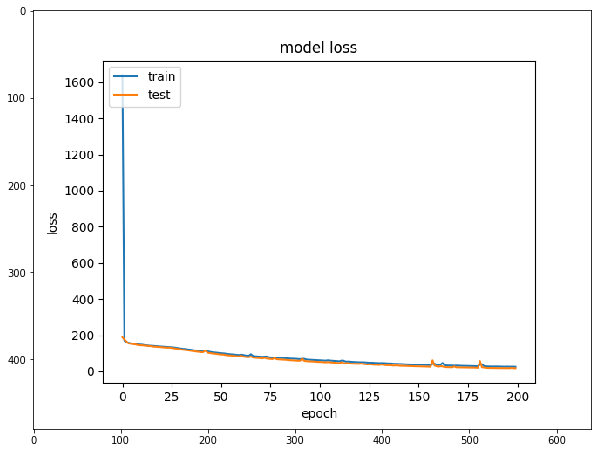

In [4]:
im1 = mpimg.imread('../media/loss_function.png')
plt.imshow(im1)

Na model smo na prej naučenih utežeh ponovili učenje še za 70 epoh. Še zmerom ni konvergiralo. (to bom še popravil, da bo vse na eni sliki in učil model zadosti dolgo, da bo konvergiralo)

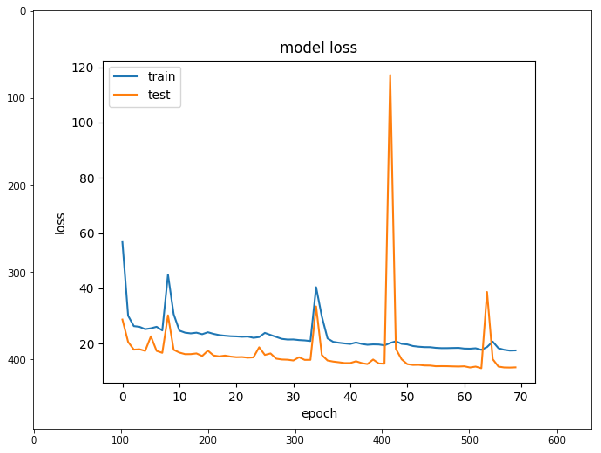

In [5]:
im2 = mpimg.imread('../media/loss_function1.png')
plt.imshow(im2)

### Uporaba vektorskih vložitev za klasifikacijo
Primer Klasifikacije na podatkovni bazi BBBP (angl. blood-brain barrier penetration) pobrane iz moleculenet.ai. Baza vsebuje 2047 kemijskih struktur in labelo ali ta kemijska struktura prehaja skozi krvno-možgansko pregrado. Podatke smo dodatno filtrerali. Odstranili smo vse strukture, ki jih ni bilo možno prevesti v prstne odtise ali jih kodirnik ni moral zakodirati, zaradi vsebujočega znaka, na katerem avtokodirnik ni bil naučen. Tako je ostalo 1927 kemijskih struktur.

In [3]:
Xvae, Xfinger, y, label, smiles = cheauder_utils.load_data('../data/BBBP.csv', encoder, 
                                                charset_filename='../code/model/charset_ZINC.json',
                                                col_smiles=3, col_target=2, delimiter=',',
                                                max_len=120)

Po priporočilih na moleculenet.ai smo za te podatke uporabili stratificirano vzorčenje (10 kratno). Uporabili smo klasifikator "extere boosting gradient" (XGB) in metodo podpornih vektorjev (SVM). "VAE" predstavlja vektorske vložitve našega kodirnika, "Fingerprints" predstavlja prstne odtise narejene s pomočjo knjižnice RDKit in "Joined" predstavlja združeni vektorski vložitvi. Za kvaliteto klasifikacije smo uporabili metriko ROC.

In [4]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=0)
svc = SVC(kernel='linear')
xgb = XGBClassifier()
classifiers = {'SVM': svc, 'XGB': xgb}
Xs = {'VAE': Xvae, 'Fingerprint': Xfinger}

cheauder_utils.classification_test(Xs, y, classifiers, n_splits=10);

VAE         | SVM    : 0.729
VAE         | XGB    : 0.722
Fingerprint | SVM    : 0.714
Fingerprint | XGB    : 0.712
Joined      | SVM    : 0.758
Joined      | XGB    : 0.739


### Izris latentnega prostora vektorskih vložitev kodirnika in prstnih odtisev

##### Graf TSNE latentnega prostora kodirnika

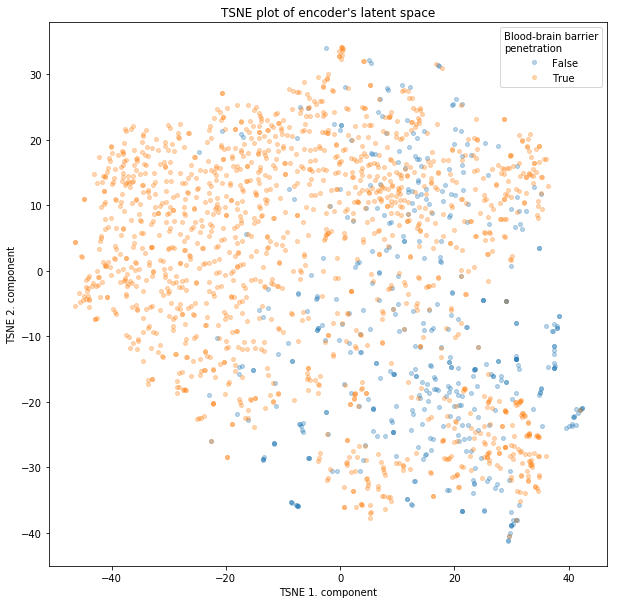

In [10]:
cheauder_utils.plot_tsne_classification(Xvae, y, 'TSNE plot of encoder\'s latent space', 'Blood-brain barrier\npenetration')

##### Graf TSNE latentnega prostora prstnih odtisev

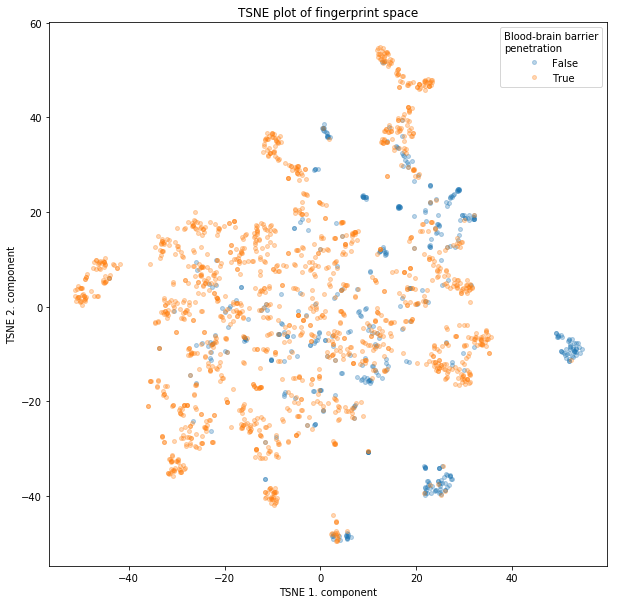

In [11]:
cheauder_utils.plot_tsne_classification(Xfinger, y, 'TSNE plot of fingerprint space', 'Blood-brain barrier\npenetration')

##### Graf TSNE združenega latentnega prostora

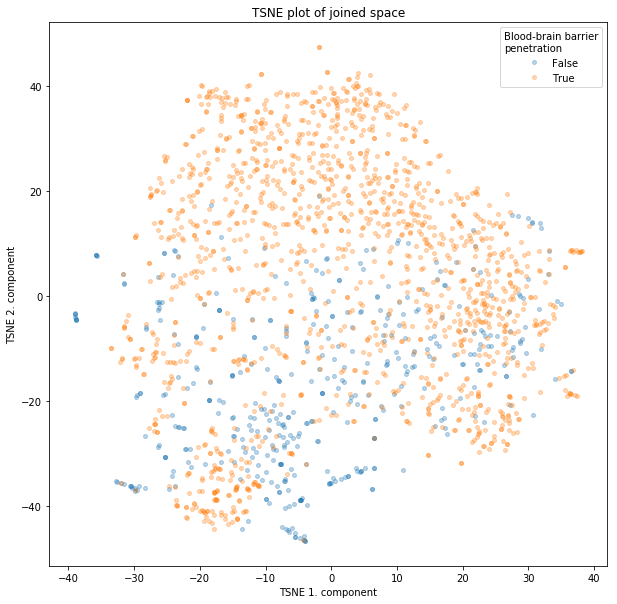

In [12]:
cheauder_utils.plot_tsne_classification(np.hstack((Xfinger, Xvae)), y, 'TSNE plot of joined space', 'Blood-brain barrier\npenetration')

#### Primerjava kvalitete vektorskih vložitev z več podatkovnimi bazami
Povprečje kvalitete klasifikacije nad šestimi različnimi klasifikacijskimi problemi vzetih iz moleculenet.ai. Prvi je enak zgornjemu. Drugi in tretji izhajata iz baze clintox z 1478 kemijskimi strukturami, kjer sta dve labeli: ali je zdravilo toksično in ali je zdravilo odobreno iz strani FDA. Zadnji trije izhajajo iz baze sider s 1427 kemijskimi strukturami, ki vsebuje stranske učinke zdravil. Mi smo vzeli tri labele, ali lahko zdravilo negativno vpliva na metabolizem, ali lahko negativno vpliva na jetra in ali lahko negativno vpliva na oči.

In [5]:
svc = SVC(kernel='linear')
xgb = XGBClassifier()
classifiers = {'SVM': svc, 'XGB': xgb}
cheauder_utils.full_classification_test(classifiers);

VAE         | SVM    : 0.641
VAE         | XGB    : 0.614
Fingerprint | SVM    : 0.607
Fingerprint | XGB    : 0.583
Joined      | SVM    : 0.674
Joined      | XGB    : 0.629
